<a href="https://colab.research.google.com/github/Vj-Ydv/Suicidal_sentiment_analysis/blob/main/Trump_tweets_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# This cell connects to google drive, authenticates connection, and iterates over file list displaying each file's title and ID.
# it also imports and installs all the necessary libraries
!pip install -U -q PyDrive
!pip install -U -q wordcloud
!pip install -U -q bokeh
!pip install textblob
!pip install sklearn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from scipy.stats import hmean
from scipy.stats import norm
from pylab import *
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from time import time

  

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [16]:
df_train = pd.read_csv('SC_Project/trump_only_text.csv', encoding='latin-1')

df_train

text    target
0      Republicans and Democrats have both created ou...  Negative
1      I was thrilled to be back in the Great city of...  Positive
2      RT @CBS_Herridge: READ: Letter to surveillance...  Negative
3      The Unsolicited Mail In Ballot Scam is a major...  Negative
4      RT @MZHemingway: Very friendly telling of even...  Positive
...                                                  ...       ...
56566  RT @RandPaul: I donÃÂ¢ÃÂÃÂt know why @Joe...  Negative
56567  RT @EliseStefanik: President @realDonaldTrump ...  Positive
56568  RT @TeamTrump: LIVE: Presidential Debate #Deba...  Negative
56569  Just signed an order to support the workers of...  Negative
56570  Suburban women want Safety &amp; Security. Joe...  Negative

[56571 rows x 2 columns]

In [17]:
#Strips emojis
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :'),:D, : D, =)
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))|:\s?D | =\)', '', tweet)
    # Sad -- :-(, : (, :(, ):, )-: , :p
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)|:p', '', tweet)
    return tweet
  

In [18]:
#clean data
url = re.compile(r"(?:(http[s]?://\S+)|((//)?(\w+\.)?\w+\.\w+/\S+))")
user_mention = re.compile(r"(?:(?<!\w)@\w+\b)")
number = re.compile(r"(?:\b\d+\b)")
repeated_char = '([a-zA-Z])\\1+'
length_repeated_char = '\\1\\1'

def clean(raw):
  #convert HTML encoding to text
  new_row = BeautifulSoup(raw, 'html.parser').get_text()
  
  #Change all text to lower case
  new_row = new_row.lower()
  
  #Replaces any url with class URL
  new_row = re.sub(url, '', new_row)
  
  #replace any @username with class USERNAME
  new_row = re.sub(user_mention, '', new_row)
  
  #Strips repeated chars
  new_row = re.sub(repeated_char, length_repeated_char, new_row)
  
  #Replaces #hashtag with hashtag
  new_row = re.sub(r'#(\S+)', r' \1 ', new_row)
  
  #Remove numbers
  new_row = re.sub(number, '', new_row)
  
  #decode text with 'utf-8-sig'
  try:
    temp_row = new_row.decode("utf-8-sig").replace(u"\ufffd", "?")     
  except:
    temp_row = new_row
  
  #Removes emojis
  new_row = handle_emojis(temp_row);
  
  return new_row

In [19]:
clean_tweets_trump = []   


In [25]:
#data preprocessing

chunks_range = [0,12000,24000,36000,56571] 
for i in range(chunks_range[3],chunks_range[4]):   #repeat for all range i.e. 0-1, 1-2, 2-3, 3-4
  clean_tweets_trump.append(clean(df_train['text'][i]))

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/iSFAokoIP7" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/ZQ0osiFEJQ" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/SmTkLPiBYD" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful S

In [26]:
len(clean_tweets_trump)

56571

In [29]:
#save to csv file
clean_df = pd.DataFrame(clean_tweets_trump, columns=['text'])
clean_df['target'] = df_train.target



In [36]:
clean_df.columns

Index(['text', 'target'], dtype='object')

In [32]:
#clean_df.to_csv('SC_Project/trump_only_text_clean.csv', encoding='utf-8')


In [39]:
clean_df.head()

text    target
0  republicans and democrats have both created ou...  Negative
1  i was thrilled to be back in the great city of...  Positive
2  rt : read: letter to surveillance court obtain...  Negative
3  the unsolicited mail in ballot scam is a major...  Negative
4  rt : very friendly telling of events here abou...  Positive

In [7]:
# upload file into pandas dataframe and drop unnecessary columns and neutral rows

# Using columns 1,2 because col 0 is the number of the row, could be changed if the row number is removed from the csv file.
df_clean = pd.read_csv('SC_Project/trump_only_text_clean.csv', usecols = [0,1], encoding='latin-1')
df_clean.head()

text    target
0                  2020security alert  u s  embas...  Negative
1                                            worst e  Negative
2                                    catherine herri  Negative
3             its normal & understandable to feel...  Negative
4                         yes but we have a rogue     Negative

In [57]:
df_clean.shape

(52626, 2)

In [45]:
from PIL import Image
from wordcloud import STOPWORDS, ImageColorGenerator

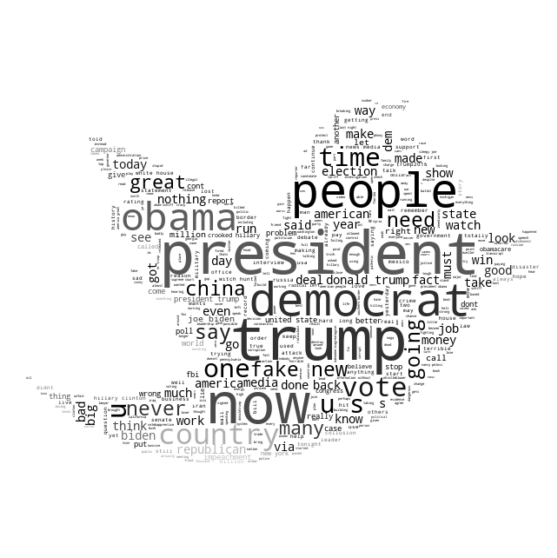

In [58]:
# Visualizing negative tweets in a word cloud format
neg_tweets = df_clean[df_clean.target == "Negative"]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

stopwords=set(STOPWORDS)
more_stopwords= {'will', 'want'}
stopwords= stopwords.union(more_stopwords)

mask_image= np.array(Image.open('images/twitter_mask.jpg'))
wordcloud = WordCloud(background_color='white', max_words=2000, mask=mask_image, stopwords=stopwords).generate(neg_string)

fig= plt.figure()
fig.set_figwidth(14)
fig.set_figheight(10)
image_colors= ImageColorGenerator(mask_image)
wordcloud.recolor(color_func=image_colors)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file('images/neg_tweets_cloud.png')


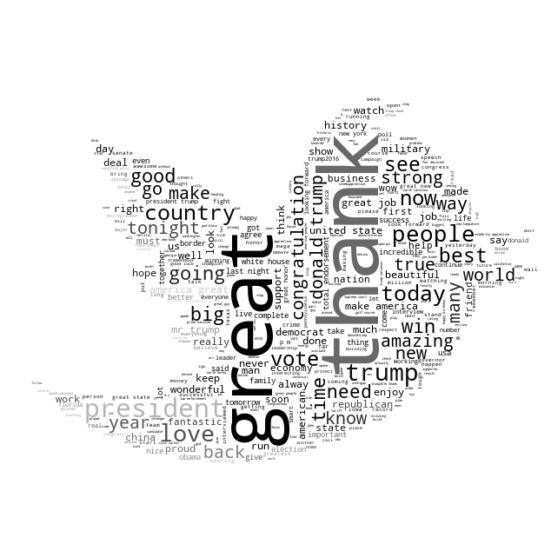

In [59]:
# Visualizing positive tweets in a word cloud format
pos_tweets = df_clean[df_clean.target == "Positive"]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
    
pos_string = pd.Series(pos_string).str.cat(sep=' ')

stopwords=set(STOPWORDS)
more_stopwords= {'will', 'want', 'im', 'u', 's', 'die', 'amp', 'one'}
stopwords= stopwords.union(more_stopwords)

mask_image= np.array(Image.open('images/twitter_mask.jpg'))
wordcloud = WordCloud(background_color='white', max_words=2000, mask=mask_image, stopwords=stopwords).generate(pos_string)

fig= plt.figure()
fig.set_figwidth(14)
fig.set_figheight(10)
image_colors= ImageColorGenerator(mask_image)
wordcloud.recolor(color_func=image_colors)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file('images/positive_tweets_cloud.png')

In [60]:
# Using CountVectorizer library to analyze frequency of words in tweets
cvec = CountVectorizer()
cvec.fit(df_clean.text)

len(cvec.get_feature_names()) # outputs total number of words


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


27529

In [61]:
# Building term frequency table to observe the most frequent words in the dataset, notice that all of them are stop words.
neg_doc_matrix = cvec.transform(df_clean[df_clean.target == "Negative"].text)
pos_doc_matrix = cvec.transform(df_clean[df_clean.target == "Positive"].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()

term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


negative  positive  total
the      25917     19667  45584
to       13832     12228  26060
and      10089     10722  20811
of        9531      8324  17855
is        9466      6583  16049
in        8397      7391  15788
for       6269      6391  12660
you       3520      8132  11652
on        5109      4938  10047
will      3363      4799   8162

Text(0.5, 1.0, 'Top 500 tokens in tweets')

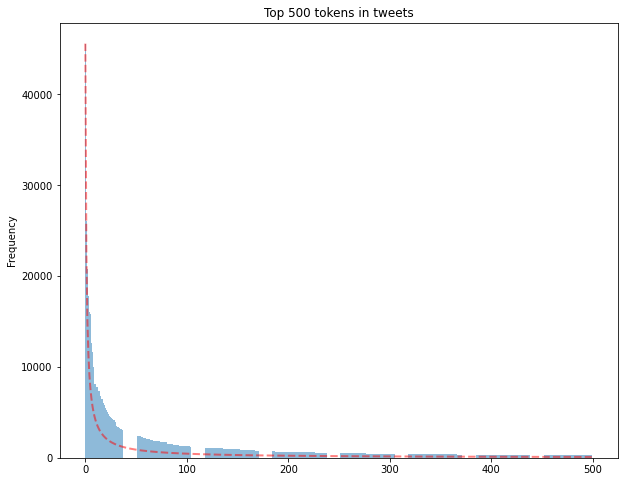

In [62]:
# Plotting tokens' frequency to see if they follow zipf's law( which states that the frequecy of the rth word => f(r) is directly prop with 1 / r)
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

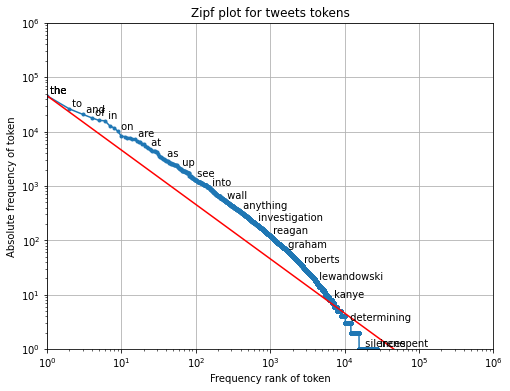

In [63]:
# Using a log-log graph, like the last one, near zipfian should be a straight line, we notice in more frequent words, their freq is above expected zipfian, and less freuent is below near zipfian
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [64]:
# Now we want to see what are the most frequent words in positive and negative tweets seperately.
cvec = CountVectorizer(stop_words='english',max_features=60000) # Removing stop words this time and limiting studied words to 10k
cvec.fit(df_clean.text)
document_matrix = cvec.transform(df_clean.text)


In [65]:
df_clean[df_clean.target == "Positive"]

text    target
27803        absolutely true, president trump  when t...  Positive
27804        is the boss   love her   cnn will never ...  Positive
27805                greatest president of my life time   Positive
27806       i totally agree   these courageous young ...  Positive
27807       is an unsung american hero and patriot  t...  Positive
...                                                  ...       ...
52621                            you're right  billions   Positive
52622  you've got something unique to offer  find out...  Positive
52623  you've got something unique to offer  find out...  Positive
52624  yvette herrell () is a proven fighter for new ...  Positive
52625  zte, the large chinese phone company, buys a b...  Positive

[24823 rows x 2 columns]

In [69]:
# Processing negative tweets
%%time
neg_batches = np.linspace(0,27802,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

3089 entries' term freuquency calculated
6178 entries' term freuquency calculated
9267 entries' term freuquency calculated
12356 entries' term freuquency calculated
15445 entries' term freuquency calculated
18534 entries' term freuquency calculated
21623 entries' term freuquency calculated
24712 entries' term freuquency calculated
27802 entries' term freuquency calculated
CPU times: user 2.15 s, sys: 554 ms, total: 2.7 s
Wall time: 3.2 s


In [70]:
# Processing positive tweets
%%time
pos_batches = np.linspace(27803,52625,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print (pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

30561 entries' term freuquency calculated
33319 entries' term freuquency calculated
36077 entries' term freuquency calculated
38835 entries' term freuquency calculated
41593 entries' term freuquency calculated
44351 entries' term freuquency calculated
47109 entries' term freuquency calculated
49867 entries' term freuquency calculated
52625 entries' term freuquency calculated
CPU times: user 2.24 s, sys: 45.3 ms, total: 2.29 s
Wall time: 2.29 s


In [71]:
# Displaying the top frequent words(non-stop) in both positive and negative tweets
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


negative  positive  total
great          1244      6138   7382
trump          3541      3210   6751
president      2521      2092   4613
people         1896      1590   3486
just           2001      1383   3384
thank           182      2985   3167
new            1129      1355   2484
country        1189      1149   2338
america         784      1419   2203
big             852      1278   2130

Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

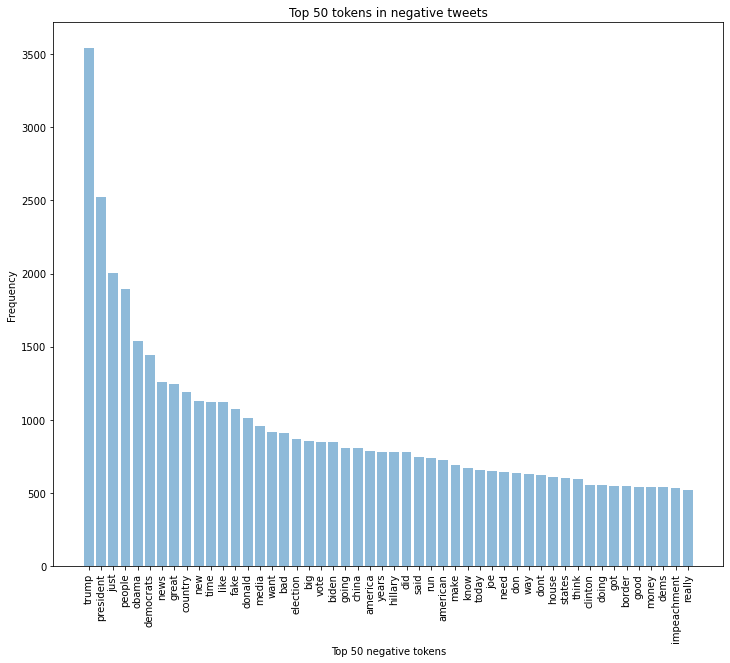

In [72]:
# Displaying most common words in negative tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')



Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

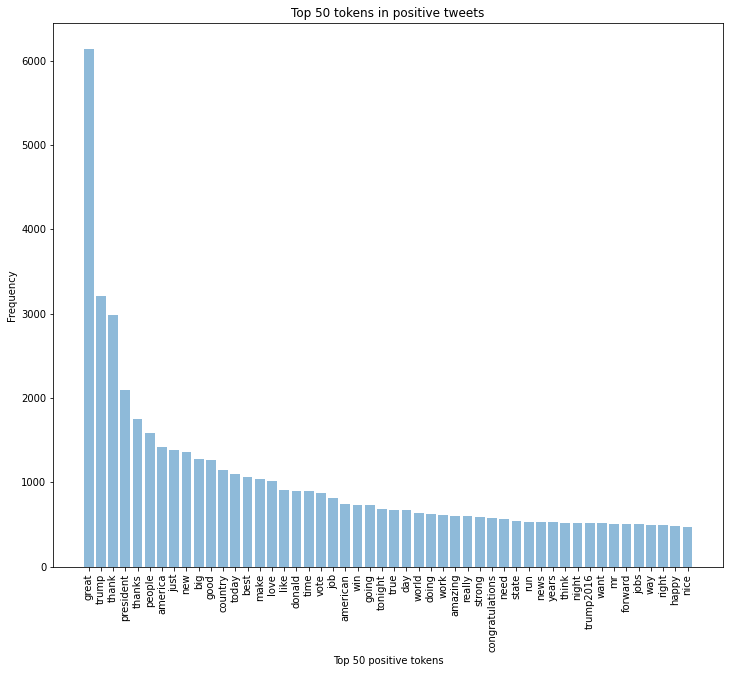

In [73]:
# Displaying most common words in positive tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

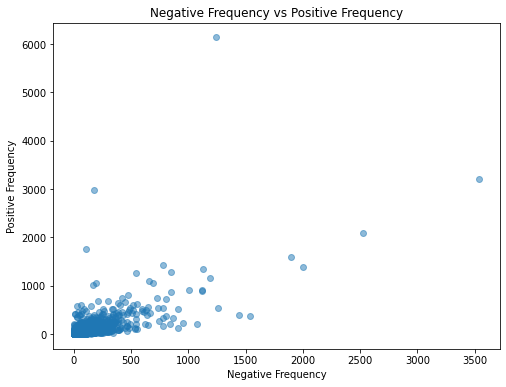

In [74]:
# We noticed in the above many neutral words occuring in both classes, let's plot the negative frequency of a word on X-axis, and the positive frequency on Y-axis
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [75]:
# As we can't infer much meaning from the previous plots, let's define a pos_rate and neg_rate, to indicate the rate of freq of a word in a certain class vs the other class
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

negative  positive  total  pos_rate
ky02                 0         1      1       1.0
intensifying         0         1      1       1.0
instruments          0         1      1       1.0
integrated           0         1      1       1.0
integration          0         2      2       1.0
inteligence          0         2      2       1.0
inteligent           0         1      1       1.0
intellects           0         1      1       1.0
intellig             0         1      1       1.0
interaction          0         1      1       1.0

In [76]:
# Now let's define a freq_pct representing the rate by which a word occurs in a certain class only
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_pct
great          1244      6138   7382  0.831482      0.026547
trump          3541      3210   6751  0.475485      0.013883
thank           182      2985   3167  0.942532      0.012910
president      2521      2092   4613  0.453501      0.009048
thanks          108      1749   1857  0.941842      0.007564
people         1896      1590   3486  0.456110      0.006877
america         784      1419   2203  0.644122      0.006137
just           2001      1383   3384  0.408688      0.005981
new            1129      1355   2484  0.545491      0.005860
big             852      1278   2130  0.600000      0.005527

In [77]:
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']]) if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)               
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_pct  pos_hmean
great          1244      6138   7382  0.831482      0.026547   0.051451
trump          3541      3210   6751  0.475485      0.013883   0.026979
thank           182      2985   3167  0.942532      0.012910   0.025471
president      2521      2092   4613  0.453501      0.009048   0.017742
thanks          108      1749   1857  0.941842      0.007564   0.015008
people         1896      1590   3486  0.456110      0.006877   0.013549
america         784      1419   2203  0.644122      0.006137   0.012158
just           2001      1383   3384  0.408688      0.005981   0.011790
new            1129      1355   2484  0.545491      0.005860   0.011596
big             852      1278   2130  0.600000      0.005527   0.010954

In [78]:
#for positive words
from scipy.stats import norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])

term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])

term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])

term_freq_df2.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

negative  positive  ...  pos_freq_pct_normcdf  pos_normcdf_hmean
awesome                 4       206  ...              0.998882           0.959594
fantastic              13       414  ...              1.000000           0.957832
enjoy                  15       417  ...              1.000000           0.956951
birthday                7       190  ...              0.997517           0.955645
congratulations        30       576  ...              1.000000           0.953791
thank                 182      2985  ...              1.000000           0.952013
thanks                108      1749  ...              1.000000           0.951857
proud                  28       354  ...              1.000000           0.948317
honor                  40       462  ...              1.000000           0.946764
luck                   15       186  ...              0.996996           0.946645

[10 rows x 9 columns]

In [79]:
#For Negative words
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']

term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()

term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])

term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])

term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])

term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

negative  positive  ...  neg_freq_pct_normcdf  neg_normcdf_hmean
disgrace            112         1  ...              0.965701           0.900798
whistleblower       148         7  ...              0.993178           0.899082
worse               254        16  ...              0.999994           0.896174
schiff              341        24  ...              1.000000           0.893473
dossier             114         4  ...              0.968339           0.893012
dishonest           193        16  ...              0.999469           0.888652
worst               238        21  ...              0.999977           0.886878
stupid              178        16  ...              0.998669           0.885750
boring              112         6  ...              0.965701           0.885455
failing             237        22  ...              0.999976           0.885171

[10 rows x 15 columns]

Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

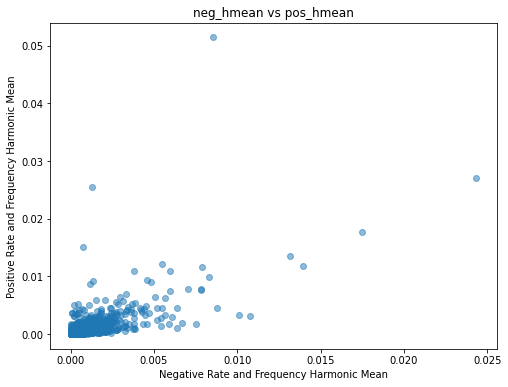

In [80]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

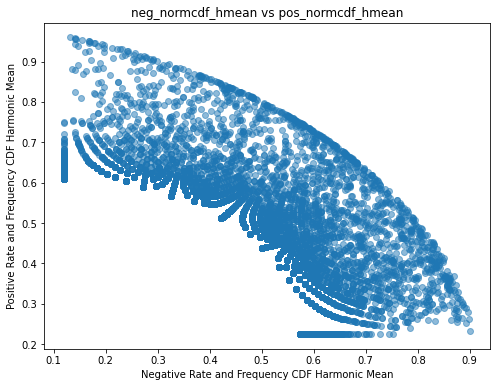

In [81]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [82]:
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))

p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')

p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})

hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

In [94]:
x = df_clean.text
y = df_clean.target

SEED = 2000

#split clean data to two sets : training , validation and test
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, random_state=SEED)
#split the second set into two other sets : validation , test 
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)


print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),(len(x_train[y_train == "Negative"]) / (len(x_train)*1.))*100,(len(x_train[y_train == "Positive"]) / (len(x_train)*1.))*100))

print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),(len(x_validation[y_validation == "Negative"]) / (len(x_validation)*1.))*100,(len(x_validation[y_validation == "Positive"]) / (len(x_validation)*1.))*100))

print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),(len(x_test[y_test == "Negative"]) / (len(x_test)*1.))*100,(len(x_test[y_test == "Positive"]) / (len(x_test)*1.))*100))




Train set has total 42100 entries with 52.96% negative, 47.04% positive
Validation set has total 5263 entries with 53.05% negative, 46.95% positive
Test set has total 5263 entries with 51.55% negative, 48.45% positive


In [95]:
print(y_validation)

4752     Negative
24357    Negative
51570    Positive
38089    Positive
20479    Negative
           ...   
41698    Positive
22646    Negative
44853    Positive
8503     Negative
24824    Negative
Name: target, Length: 5263, dtype: object


In [96]:
# Using Text Blob Python libary for sentiment analysis as baseline for accuracy

tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
target_names = ['Positive', 'Negative']
tbpred = ["Negative" if n < 0 else "Positive" for n in tbresult]
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=["Positive","Negative"]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])

print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples.

# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, 
# where an F-beta score reaches its best value at 1 and worst score at 0.
print ("Classification Report\n")
print (classification_report(y_validation, tbpred,target_names=target_names))

Accuracy Score: 60.80%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                2333                 138
negative                1925                 867
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    Positive       0.86      0.31      0.46      2792
    Negative       0.55      0.94      0.69      2471

    accuracy                           0.61      5263
   macro avg       0.71      0.63      0.58      5263
weighted avg       0.71      0.61      0.57      5263



In [97]:
#calculate accuracy for any classifer using {"null accuracy"} and get total time for training and testing
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time


In [98]:
def nfeature_accuracy_checker(vectorizer=None, n_features=None, stop_words=None, ngram_range=(1, 1), classifier=None):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [99]:
#calculate accuracy for any classifer using {"null accuracy"} and get total time for training and testing
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == "Negative"]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == "Negative"]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == "Negative"]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time


In [103]:
# Using count vectorizer to extract features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(5000,55001,5000)


# Unigrams without stop words
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words='english', classifier=lr)


RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression()


Validation result for 5000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 82.44%
model is 29.39% more accurate than null accuracy
train and test time: 1.81s
--------------------------------------------------------------------------------
Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 82.33%
model is 29.28% more accurate than null accuracy
train and test time: 2.20s
--------------------------------------------------------------------------------
Validation result for 15000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 82.39%
model is 29.34% more accurate than null accuracy
train and test time: 2.84s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 82.33%
model is 29.28% more accurate than null accuracy
train and test time: 2.86s
--------------------------------------------------------------------------------
Validation result for 25000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 82.39%
model is 29.34% more accurate than null accuracy
train and test time: 2.72s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 82.39%
model is 29.34% more accurate than null accuracy
train and test time: 2.89s
--------------------------------------------------------------------------------
Validation result for 35000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 82.39%
model is 29.34% more accurate than null accuracy
train and test time: 2.92s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 82.39%
model is 29.34% more accurate than null accuracy
train and test time: 3.03s
--------------------------------------------------------------------------------
Validation result for 45000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 82.39%
model is 29.34% more accurate than null accuracy
train and test time: 3.09s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 82.39%
model is 29.34% more accurate than null accuracy
train and test time: 2.90s
--------------------------------------------------------------------------------
Validation result for 55000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 82.39%
model is 29.34% more accurate than null accuracy
train and test time: 3.00s
--------------------------------------------------------------------------------


In [104]:
# Unigrams with stop words 
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, classifier=lr)

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 5000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 83.83%
model is 30.78% more accurate than null accuracy
train and test time: 2.00s
--------------------------------------------------------------------------------
Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.36%
model is 31.31% more accurate than null accuracy
train and test time: 2.42s
--------------------------------------------------------------------------------
Validation result for 15000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.17%
model is 31.12% more accurate than null accuracy
train and test time: 3.05s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 83.94%
model is 30.89% more accurate than null accuracy
train and test time: 2.99s
--------------------------------------------------------------------------------
Validation result for 25000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.21%
model is 31.16% more accurate than null accuracy
train and test time: 3.11s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.10%
model is 31.05% more accurate than null accuracy
train and test time: 3.25s
--------------------------------------------------------------------------------
Validation result for 35000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.10%
model is 31.05% more accurate than null accuracy
train and test time: 4.83s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.10%
model is 31.05% more accurate than null accuracy
train and test time: 6.41s
--------------------------------------------------------------------------------
Validation result for 45000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.10%
model is 31.05% more accurate than null accuracy
train and test time: 4.93s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.10%
model is 31.05% more accurate than null accuracy
train and test time: 3.24s
--------------------------------------------------------------------------------
Validation result for 55000 features
null accuracy: 53.05%
accuracy score: 84.10%
model is 31.05% more accurate than null accuracy
train and test time: 3.27s
--------------------------------------------------------------------------------
CPU times: user 34.1 s, sys: 21.9 s, total: 56 s
Wall time: 39.7 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [105]:
# Defining custom stop words as top 10 most frequent words in the dataset
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

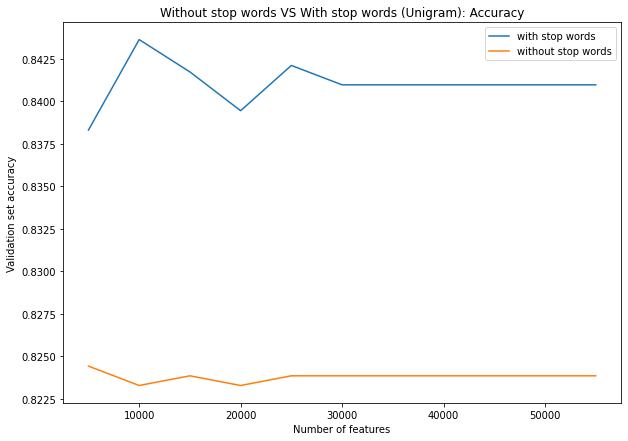

In [106]:
# Plotting the 2 cases of unigrams against each other (with stop words, without stop words)
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(10,7))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

# NOTE: Results showed that training with stop words produces a better accuracy, so bigrams and trigrams will be processed with stop words

In [107]:
# Bigrams
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, ngram_range=(1, 2), classifier=lr)

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 5000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 83.45%
model is 30.40% more accurate than null accuracy
train and test time: 5.39s
--------------------------------------------------------------------------------
Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.19%
model is 31.14% more accurate than null accuracy
train and test time: 4.91s
--------------------------------------------------------------------------------
Validation result for 15000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.04%
model is 30.99% more accurate than null accuracy
train and test time: 5.61s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 83.91%
model is 30.86% more accurate than null accuracy
train and test time: 5.55s
--------------------------------------------------------------------------------
Validation result for 25000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 83.89%
model is 30.84% more accurate than null accuracy
train and test time: 7.95s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.13%
model is 31.08% more accurate than null accuracy
train and test time: 6.18s
--------------------------------------------------------------------------------
Validation result for 35000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.34%
model is 31.29% more accurate than null accuracy
train and test time: 8.19s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.19%
model is 31.14% more accurate than null accuracy
train and test time: 8.14s
--------------------------------------------------------------------------------
Validation result for 45000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.55%
model is 31.50% more accurate than null accuracy
train and test time: 8.16s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.42%
model is 31.37% more accurate than null accuracy
train and test time: 7.99s
--------------------------------------------------------------------------------
Validation result for 55000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.36%
model is 31.31% more accurate than null accuracy
train and test time: 7.41s
--------------------------------------------------------------------------------


In [108]:
# Triagrams
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, ngram_range=(1, 3), classifier=lr)


RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 5000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 83.41%
model is 30.36% more accurate than null accuracy
train and test time: 8.11s
--------------------------------------------------------------------------------
Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.06%
model is 31.01% more accurate than null accuracy
train and test time: 8.64s
--------------------------------------------------------------------------------
Validation result for 15000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 83.93%
model is 30.88% more accurate than null accuracy
train and test time: 9.18s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.10%
model is 31.05% more accurate than null accuracy
train and test time: 9.45s
--------------------------------------------------------------------------------
Validation result for 25000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 83.74%
model is 30.69% more accurate than null accuracy
train and test time: 13.95s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.02%
model is 30.97% more accurate than null accuracy
train and test time: 9.66s
--------------------------------------------------------------------------------
Validation result for 35000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.06%
model is 31.01% more accurate than null accuracy
train and test time: 9.79s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.25%
model is 31.20% more accurate than null accuracy
train and test time: 9.65s
--------------------------------------------------------------------------------
Validation result for 45000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.32%
model is 31.27% more accurate than null accuracy
train and test time: 9.84s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.42%
model is 31.37% more accurate than null accuracy
train and test time: 10.37s
--------------------------------------------------------------------------------
Validation result for 55000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.63%
model is 31.58% more accurate than null accuracy
train and test time: 10.33s
--------------------------------------------------------------------------------


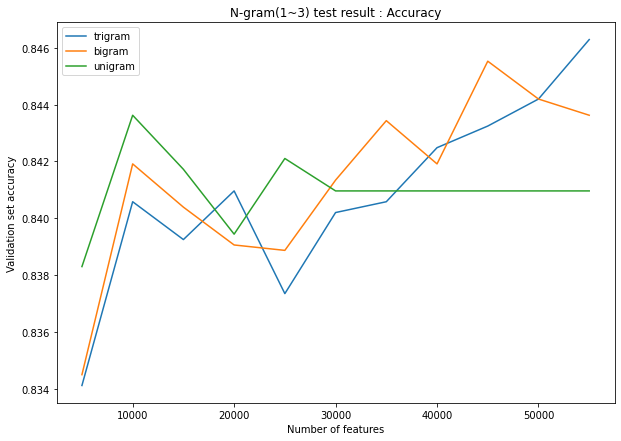

In [109]:
# Plotting Unigrams Vs Biagrams vs Triagrams on the same graph

nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(10,7))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()


In [112]:
#using Tfidf algorithm to extract features
tvec = TfidfVectorizer()
lr = LogisticRegression()
n_features = np.arange(5000,55001,5000)


In [113]:
#with stopwords in dataset
feature_result_ugt_sw = nfeature_accuracy_checker(vectorizer=tvec, n_features=n_features, classifier=lr)


LogisticRegression()


Validation result for 5000 features
null accuracy: 53.05%
accuracy score: 84.15%
model is 31.10% more accurate than null accuracy
train and test time: 2.05s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 53.05%
accuracy score: 84.69%
model is 31.64% more accurate than null accuracy
train and test time: 2.18s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 53.05%
accuracy score: 84.69%
model is 31.64% more accurate than null accuracy
train and test time: 3.06s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 53.05%
accuracy score: 84.63%
model is 31.58% more accurate than null accuracy
train and test time: 3.40s
--------------------------------------------------------------------------------
Validation result for 

In [114]:
#with out stop words in data set
feature_result_ugt_out_sw = nfeature_accuracy_checker(vectorizer=tvec, n_features=n_features, stop_words='english', classifier=lr)

LogisticRegression()


Validation result for 5000 features
null accuracy: 53.05%
accuracy score: 83.20%
model is 30.15% more accurate than null accuracy
train and test time: 1.53s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 53.05%
accuracy score: 83.20%
model is 30.15% more accurate than null accuracy
train and test time: 1.77s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 53.05%
accuracy score: 83.26%
model is 30.21% more accurate than null accuracy
train and test time: 2.00s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 53.05%
accuracy score: 83.22%
model is 30.17% more accurate than null accuracy
train and test time: 1.98s
--------------------------------------------------------------------------------
Validation result for 

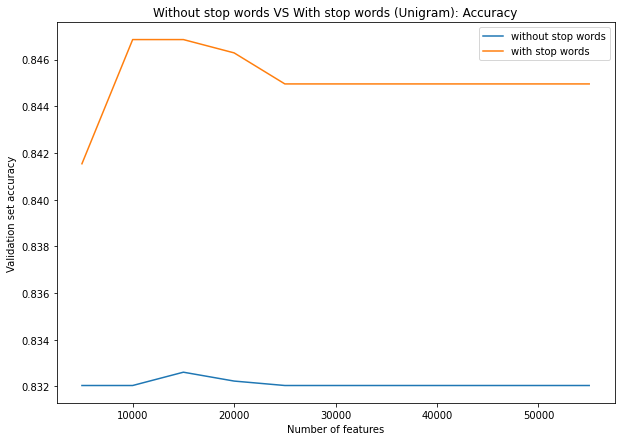

In [115]:
# unigrams against each other (with stop words, with custom stop words, without stop words) In TfIDF
nfeatures_plot_ugt_out_sw = pd.DataFrame(feature_result_ugt_out_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt_sw = pd.DataFrame(feature_result_ugt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(10,7))
plt.plot(nfeatures_plot_ugt_out_sw.nfeatures, nfeatures_plot_ugt_out_sw.validation_accuracy, label='without stop words')
plt.plot(nfeatures_plot_ugt_sw.nfeatures, nfeatures_plot_ugt_sw.validation_accuracy,label='with stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [116]:
#Bigram with stop words
feature_result_bgt_sw = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(1, 2), classifier=lr)


LogisticRegression()


Validation result for 5000 features
null accuracy: 53.05%
accuracy score: 84.29%
model is 31.24% more accurate than null accuracy
train and test time: 5.95s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 53.05%
accuracy score: 84.74%
model is 31.69% more accurate than null accuracy
train and test time: 4.73s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 53.05%
accuracy score: 84.53%
model is 31.48% more accurate than null accuracy
train and test time: 6.61s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 53.05%
accuracy score: 84.57%
model is 31.52% more accurate than null accuracy
train and test time: 9.16s
--------------------------------------------------------------------------------
Validation result for 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.67%
model is 31.62% more accurate than null accuracy
train and test time: 6.32s
--------------------------------------------------------------------------------
Validation result for 45000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.69%
model is 31.64% more accurate than null accuracy
train and test time: 6.68s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 53.05%
accuracy score: 84.61%
model is 31.56% more accurate than null accuracy
train and test time: 6.17s
--------------------------------------------------------------------------------
Validation result for 55000 features
null accuracy: 53.05%
accuracy score: 84.72%
model is 31.67% more accurate than null accuracy
train and test time: 5.56s
--------------------------------------------------------------------------------


In [117]:
#Trigram with stop words
feature_result_tgt_sw = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(1, 3), classifier=lr)


LogisticRegression()


Validation result for 5000 features
null accuracy: 53.05%
accuracy score: 84.13%
model is 31.08% more accurate than null accuracy
train and test time: 8.07s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 53.05%
accuracy score: 84.76%
model is 31.71% more accurate than null accuracy
train and test time: 8.03s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 53.05%
accuracy score: 84.48%
model is 31.43% more accurate than null accuracy
train and test time: 10.29s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 53.05%
accuracy score: 84.38%
model is 31.33% more accurate than null accuracy
train and test time: 11.55s
--------------------------------------------------------------------------------
Validation result fo

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 84.42%
model is 31.37% more accurate than null accuracy
train and test time: 9.93s
--------------------------------------------------------------------------------
Validation result for 35000 features
null accuracy: 53.05%
accuracy score: 84.29%
model is 31.24% more accurate than null accuracy
train and test time: 11.30s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 53.05%
accuracy score: 84.29%
model is 31.24% more accurate than null accuracy
train and test time: 8.96s
--------------------------------------------------------------------------------
Validation result for 45000 features
null accuracy: 53.05%
accuracy score: 84.34%
model is 31.29% more accurate than null accuracy
train and test time: 10.14s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 53.05%
accuracy score: 84.2

In [118]:
feature_result_tgt_sw_3_3 = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(3, 3), classifier=lr)

LogisticRegression()


Validation result for 5000 features
null accuracy: 53.05%
accuracy score: 69.37%
model is 16.32% more accurate than null accuracy
train and test time: 4.66s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 53.05%
accuracy score: 70.36%
model is 17.31% more accurate than null accuracy
train and test time: 5.02s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 53.05%
accuracy score: 71.12%
model is 18.07% more accurate than null accuracy
train and test time: 5.29s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 53.05%
accuracy score: 71.42%
model is 18.37% more accurate than null accuracy
train and test time: 5.82s
--------------------------------------------------------------------------------
Validation result for 25000 features
null accuracy: 53.05%
accuracy score: 71.82%
model is 18.77% more accurate than null accuracy
train and test time: 6.76s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 53.05%
accuracy score: 71.99%
model is 18.94% more accurate than null accuracy
train and test time: 7.53s
--------------------------------------------------------------------------------
Validation result for 35000 features
null accuracy: 53.05%
accuracy score: 71.97%
model is 18.92% more accurate than null accuracy
train and test time: 5.78s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 53.05%
accuracy score: 72.05%

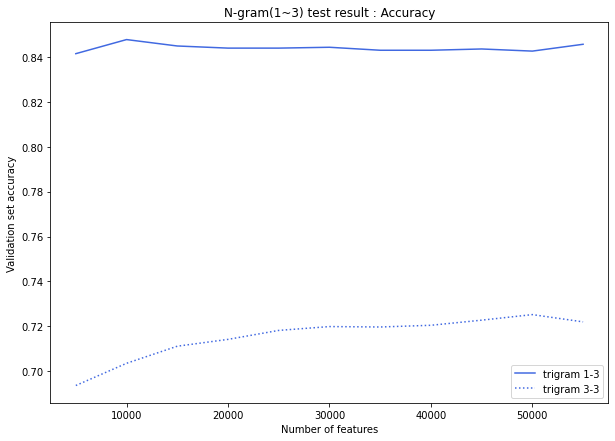

In [119]:
# Plotting trigram (1,3) features Vs trigram (3,3) features


nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tgt_3_3 = pd.DataFrame(feature_result_tgt_sw_3_3,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(10,7))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram 1-3',color='royalblue')
plt.plot(nfeatures_plot_tgt_3_3.nfeatures, nfeatures_plot_tgt_3_3.validation_accuracy,label='trigram 3-3',linestyle=':', color='royalblue')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

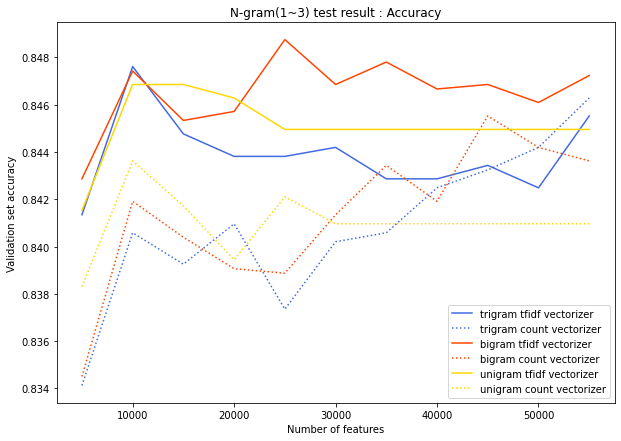

In [120]:
# Plotting Unigrams Vs Biagrams vs Triagrams on the same graph based on (countvectorizer & tfidf)

nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(10,7))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [121]:
# Trying several classifiers and comparison between them 

from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()

#comparator to compare between accuracy of different zipped classifiers

def classifier_comparator(vectorizer=tvec, n_features=None, stop_words=None, ngram_range=None, classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

trigram_result = classifier_comparator(n_features=50000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression()
null accuracy: 53.05%
accuracy score: 84.25%
model is 31.20% more accurate than null accuracy
train and test time: 10.07s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 53.05%
accuracy score: 84.42%
model is 31.37% more accurate than null accuracy
train and test time: 8.09s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', LinearSVC())])
null accuracy: 53.05%
accuracy score: 84.55%
model is 31.50% more accurate than null accuracy
train and test time: 12.87s
------------------------------------------------------------------------------

In [123]:
#use top 5 of classifiers and use VotingClassifier with voting hard
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = Perceptron()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('per', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')
checker_pipeline = Pipeline([
              ('vectorizer', TfidfVectorizer(max_features=50000,ngram_range=(1, 3))),
              ('classifier', eclf)
])
print ("Validation result for {}".format('Ensemble'))
print (eclf)
accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)


Validation result for Ensemble
VotingClassifier(estimators=[('lr', LogisticRegression()), ('svc', LinearSVC()),
                             ('per', Perceptron()), ('rcs', RidgeClassifier()),
                             ('pac', PassiveAggressiveClassifier())])
null accuracy: 53.05%
accuracy score: 84.15%
model is 31.10% more accurate than null accuracy
train and test time: 13.55s
--------------------------------------------------------------------------------


(0.8415352460573817, 13.551616907119751)

In [2]:
from keras.models import Sequential
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer

import pickle

In [8]:
cv= CountVectorizer()
Xnew = cv.fit_transform(df_clean.text).toarray()

In [9]:
Xnewdf= pd.DataFrame(Xnew)
Xnewdf.head()

0      1      2      3      4      ...  27524  27525  27526  27527  27528
0      0      0      0      0      0  ...      0      0      0      0      0
1      0      0      0      0      0  ...      0      0      0      0      0
2      0      0      0      0      0  ...      0      0      0      0      0
3      0      0      0      0      0  ...      0      0      0      0      0
4      0      0      0      0      0  ...      0      0      0      0      0

[5 rows x 27529 columns]